# Multi-label Text Classification with BERT and PyTorch Lightning

> TL;DR Learn how to prepare a dataset with toxic comments for multi-label text classification (tagging). We'll fine-tune BERT using PyTorch Lightning and evaluate the model.

Multi-label text classification (or tagging text) is one of the most common tasks you'll encounter when doing NLP. Modern Transformer-based models (like BERT) make use of pre-training on vast amounts of text data that makes fine-tuning faster, use fewer resources and more accurate on small(er) datasets.

In this tutorial, you'll learn how to:

- Load, balance and split text data into sets
- Tokenize text (with BERT tokenizer) and create PyTorch dataset
- Fine-tune BERT model with PyTorch Lightning
- Find out about warmup steps and use a learning rate scheduler
- Use area under the ROC and binary cross-entropy to evaluate the model during training
- How to make predictions using the fine-tuned BERT model
- Evaluate the performance of the model for each class (possible comment tag)

Will our model be any good for toxic text detection?

- [Read the tutorial](https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/14Ea4lIzsn5EFvPpYKtWStXEByT9qmbkj?usp=sharing)
- [Read the *Getting Things Done with Pytorch* book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

In [1]:
!nvidia-smi

Mon Apr 25 09:28:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip3 install pytorch-lightning==1.3 --quiet
!pip3 install transformers==4.5.1 --quiet

In [2]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

## Data

Our dataset contains potentially offensive (toxic) comments and comes from the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Let's start by download the data (from Google Drive):

Let's load and look at the data:

In [5]:
df = pd.read_csv("fics_SMALL.csv")
print(df.head())
df = df.drop(labels=['title', 'author', 'rating', 'category', 'fandom', 'relationship', 'character', 'language',\
               'published', 'status', 'status date', 'words', 'chapters', 'comments', 'kudos', 'bookmarks',\
                'hits', 'all_kudos', 'all_bookmarks'], axis=1)

for x in range(len(df)):
    df.at[x, 'body'] = df.at[x, 'body'][:1500]

len(df)

    work_id                                         title              author  \
0  27273463  if i choose not to see it, it does not exist        ['inareese']   
1  27839599                           Talks about Nothing      ['tzitzimeme']   
2  28939320                        the bird without wings                  []   
3  27171623                  more espresso, less depresso  ['birdsofpassage']   
4  28048341                                  take me home       ['macademia']   

                  rating category                                    fandom  \
0  Teen And Up Audiences      M/M  Yuan Shen  | Genshin Impact (Video Game)   
1  Teen And Up Audiences      M/M  Yuan Shen  | Genshin Impact (Video Game)   
2  Teen And Up Audiences      M/M  Yuan Shen  | Genshin Impact (Video Game)   
3  Teen And Up Audiences      M/M  Yuan Shen  | Genshin Impact (Video Game)   
4  Teen And Up Audiences      M/M  Yuan Shen  | Genshin Impact (Video Game)   

                                      

620

Now let's analyse the 'additional tags' data.

In [4]:
tagslist = df.loc[0]['additional tags'].split(", ")
tagsdict = {}
for x in range(620):
    tagslist = str(df.loc[x]['additional tags']).split(", ")
    for y in tagslist:
        try:
            tagsdict[y] += 1
        except:
            tagsdict[y] = 1
            
sdtaglist = []     

for x in tagsdict:
    t = [x]
    t.append(tagsdict[x])
    sdtaglist.append(t)
            
sdtaglist.sort(reverse=True, key=lambda a: a[1])

#sddict = dict(sdtaglist[:100])
#print(sddict)
#print(sdtaglist)

f1 = {"tags": [], "count": []}
for x in sdtaglist[:100]:
    f1['tags'].append(x[0])
    f1['count'].append(x[1])
#print(f1)

tagdf = pd.DataFrame.from_dict(f1)
tagdf = tagdf.drop(index=range(10,100))
tagdf.head(n=15)
#tagdf.plot(kind="barh", x="tags", y="count");

,tags,count
0,Fluff,264
1,Hurt/Comfort,75
2,Angst,62
3,Alternate Universe - Modern Setting,59
4,Mutual Pining,54
5,Established Relationship,53
6,Light Angst,46
7,Love Confessions,44
8,Pining,43
9,Fluff and Humor,42


We can see that the top ten most popular tags (sans a few cherry-picked ones) in the category we're drawing from are the above ('Fluff', 'Hurt/Comfort', 'Angst', etc.) We now turn to organizing our data.

In [6]:
for y in tagdf.tags:
    print(y)

Fluff
Hurt/Comfort
Angst
Alternate Universe - Modern Setting
Mutual Pining
Established Relationship
Light Angst
Love Confessions
Pining
Fluff and Humor


In [7]:
df = df.rename(columns={"additional tags": "additional_tags"})
#for y in tagdf.tags:
#    df.assign(y=lambda x: 1 if str(y) in x.additional_tags else 0)
df = df.assign(Fluff=0, Hurt_Comfort=0, Angst=0, \
               AU_Modern=0, Mutual_Pining=0, Established_Relationship=0, \
               Light_Angst=0, Love_Confessions=0, Pining=0, Fluff_Humor=0)


"""
Ass code, cannot figure out why lambda doesn't work during
generation, it just takes the first row's value for all of the rest,
which is really annoying and useless

"""

def presadd(namesandids):
    for tagname, tagid in namesandids:
        for x in range(len(df)):
            if tagname in str(df.at[x, 'additional_tags']): 
                df.at[x, tagid] = 1
            else:
                df.at[x, tagid] = 0
            
tag_names_and_ids = [['Fluff', 'Fluff'], ['Hurt/Comfort', 'Hurt_Comfort'],\
                     ['Angst', 'Angst'], ['Alternate Universe - Modern Setting', 'AU_Modern'],\
                     ['Mutual Pining', 'Mutual_Pining'], ['Established Relationship', 'Established_Relationship'],\
                     ['Light Angst', 'Light_Angst'], ['Love Confessions', 'Love_Confessions'],\
                     ['Pining', 'Pining'], ['Fluff and Humor', 'Fluff_Humor']]

presadd(tag_names_and_ids)

df = df.drop(labels='additional_tags', axis=1)
df.head(n=15) #is it useful to delete works without any of the 'top ten' tags that have been selected here? add code:

,work_id,body,Fluff,Hurt_Comfort,Angst,AU_Modern,Mutual_Pining,Established_Relationship,Light_Angst,Love_Confessions,Pining,Fluff_Humor
0,27273463,The problem is that Zhongli doesn't just kick ...,0,0,0,0,0,0,0,0,0,0
1,27839599,All of them show up when Zhongli invites them ...,0,0,0,0,0,0,0,0,0,0
2,28939320,"When Kaeya turned eight, he celebrated his bir...",0,1,0,0,0,0,0,0,0,0
3,27171623,Zhongli is trying to rearrange the cups on the...,1,0,0,0,0,0,0,0,0,0
4,28048341,Venti was drunk. Drunk for the nth time and ca...,0,0,0,0,0,1,0,0,0,0
5,27961157,"The chilly forest wind blows against his skin,...",0,0,0,1,0,0,0,0,0,0
6,27866538,"Sleepovers were a rare occurence, though lucki...",1,0,0,0,0,0,0,0,0,1
7,28822683,Kaeya is a fascinating annoyance.\n\nIt's been...,0,0,0,0,0,0,0,0,0,0
8,27735967,\nTonia\n\n\n \n\nBrother's letters are always...,1,0,0,0,0,0,0,0,0,0
9,27932545,Shortly after their entrance into the Imperial...,0,0,0,0,0,0,0,0,0,0


We have text (comment) and six different toxic labels. Note that we have clean content, too. 

Let's split the data:

In [8]:
train_df, val_df = train_test_split(df, test_size=0.05)
train_df.shape, val_df.shape

((589, 12), (31, 12))

## Preprocessing

Let's look at the distribution of the labels:

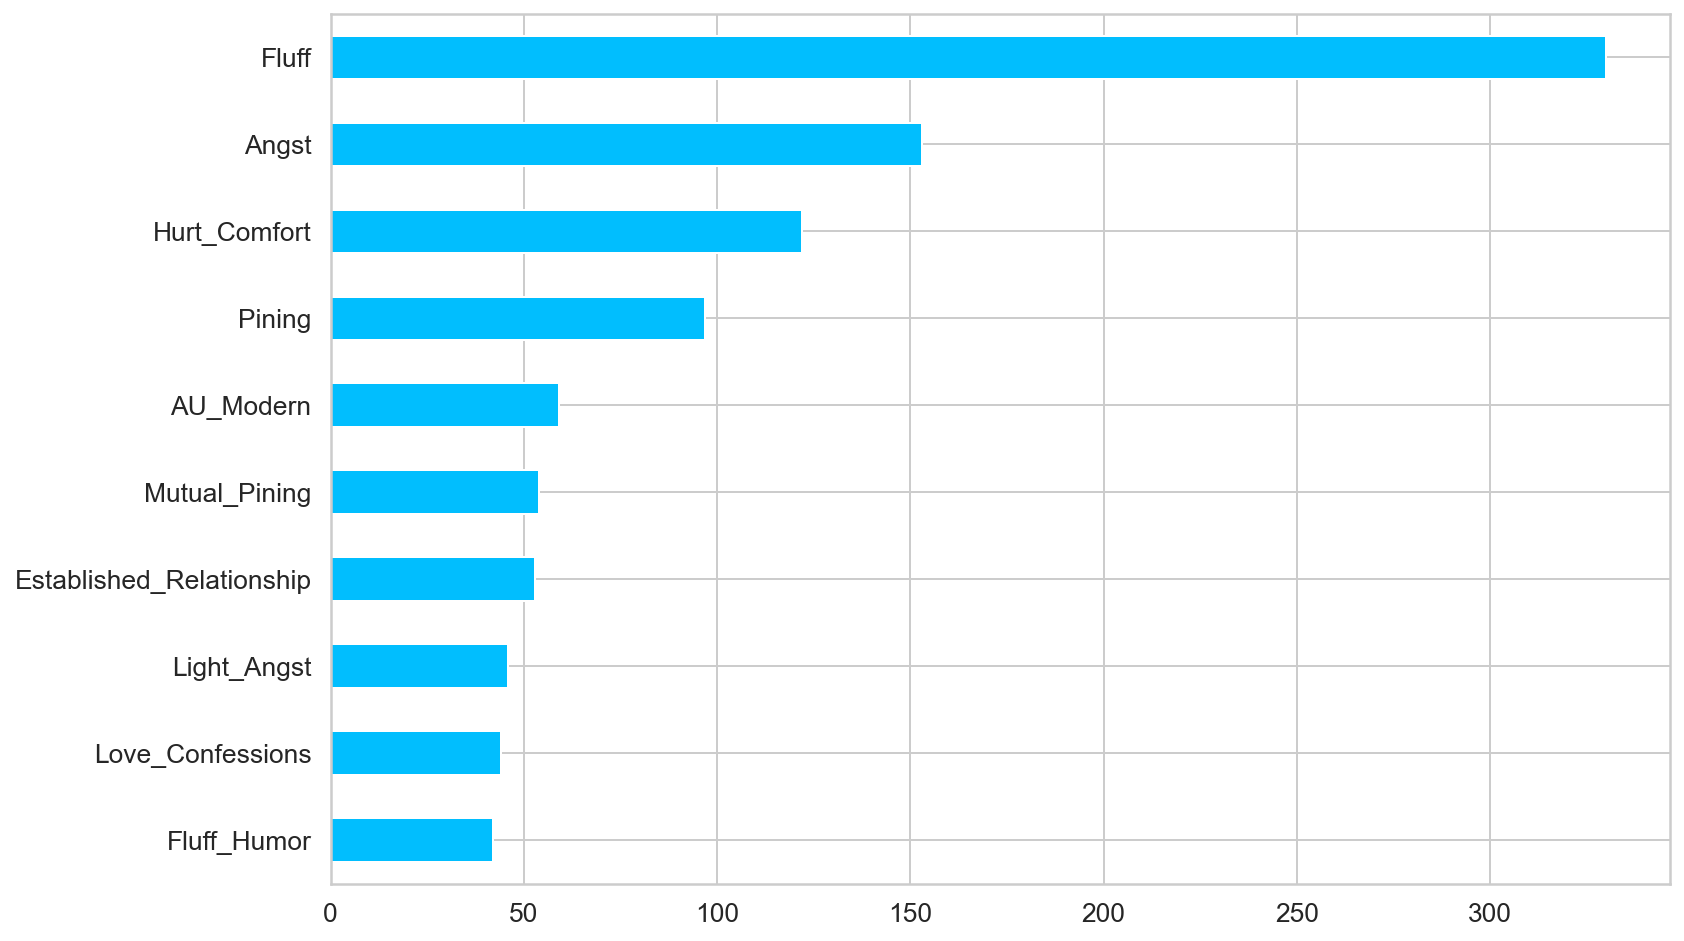

In [9]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

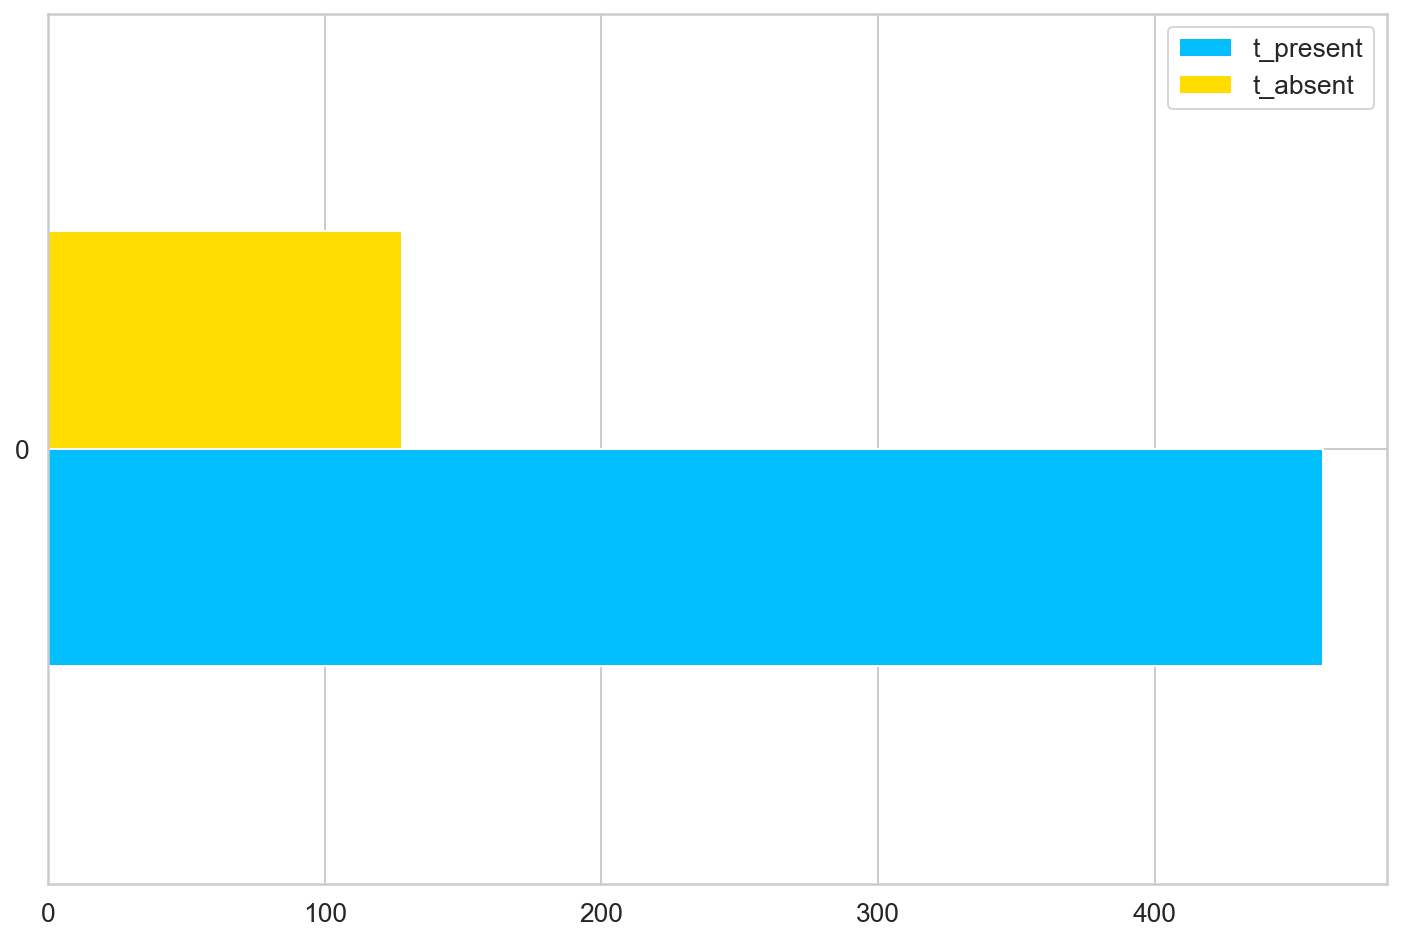

In [10]:
train_tags_present = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_tags_absent = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  t_present=[len(train_tags_present)], 
  t_absent=[len(train_tags_absent)]
)).plot(kind='barh');

Again, we have a severe imbalance in favor of the clean comments. To combat this, we'll sample 15,000 examples from the clean comments and create a new training set:

In [11]:
train_df = pd.concat([
  train_tags_present.sample(150),
  train_tags_absent
])

train_df.shape, val_df.shape

((278, 12), (31, 12))

### Tokenization

We need to convert the raw text into a list of tokens. For that, we'll use the built-in BertTokenizer:

In [12]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Let's try it out on a sample comment:

In [13]:
sample_row = df.iloc[16]
sample_comment = sample_row.body
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print()
print(sample_labels.to_dict())

There was Harbinger in his fucking city. In his bar, to be specific - sitting across from him nursing his fourth glass of Fontaine-imported golden champagne with a dopey smile on his face. He couldn't even ask for a flute like a civilized person, he had specifically requested a fat square glass and started pouring.

"This is pretty good," Childe slurred, picking up the glass with one languid hand and swirling the wine obnoxiously. "Hey. You should serve at my wedding."

Why was he talking to him. Diluc plastered a friendly smile to his face and said, "Don't you think you've had enough for tonight?"

"Ha! I said it was good, not that it was strong. If Mondstadtian wine is a candle, then Snezhnayan firewater is the sun. My folks, where I'm from, they'd laugh themselves silly if I couldn't handle a bit of shiny piss-looking liquid like this. Do you want to see my ring?"

No. "Sir, you've already shown me your ring seventeen - "

"It's beautiful, isn't it?" said Childe dreamily, sticking h

In [14]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [15]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

The result of the encoding is a dictionary with token ids `input_ids` and an attention mask `attention_mask` (which tokens should be used by the model 1 - use or 0 - don't use).

Let's look at their contents:

In [16]:
encoding["input_ids"].squeeze()[:20]

tensor([  101,  1247,  1108, 11679, 26281,  7728,  1107,  1117,  8750,  1331,
          119,  1130,  1117,  2927,   117,  1106,  1129,  2747,   118,  2807])

In [17]:
encoding["attention_mask"].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

You can also inverse the tokenization and get back (kinda) the words from the token ids:

In [18]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze()))

['[CLS]', 'There', 'was', 'Ha', '##rb', '##inger', 'in', 'his', 'fucking', 'city', '.', 'In', 'his', 'bar', ',', 'to', 'be', 'specific', '-', 'sitting', 'across', 'from', 'him', 'nursing', 'his', 'fourth', 'glass', 'of', 'F', '##ontaine', '-', 'imported', 'golden', 'champagne', 'with', 'a', 'do', '##pe', '##y', 'smile', 'on', 'his', 'face', '.', 'He', 'couldn', "'", 't', 'even', 'ask', 'for', 'a', 'flute', 'like', 'a', 'civil', '##ized', 'person', ',', 'he', 'had', 'specifically', 'requested', 'a', 'fat', 'square', 'glass', 'and', 'started', 'pouring', '.', '"', 'This', 'is', 'pretty', 'good', ',', '"', 'Child', '##e', 's', '##lu', '##rred', ',', 'picking', 'up', 'the', 'glass', 'with', 'one', 'la', '##ng', '##uid', 'hand', 'and', 'swirling', 'the', 'wine', 'o', '##b', '##no', '##xious', '##ly', '.', '"', 'Hey', '.', 'You', 'should', 'serve', 'at', 'my', 'wedding', '.', '"', 'Why', 'was', 'he', 'talking', 'to', 'him', '.', 'Di', '##lu', '##c', 'plastered', 'a', 'friendly', 'smile', 'to

We need to specify the maximum number of tokens when encoding (512 is the maximum we can do). Let's check the number of tokens per comment:

In [19]:
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["body"], 
    max_length=512, 
    truncation=True
  ))
  token_counts.append(token_count)

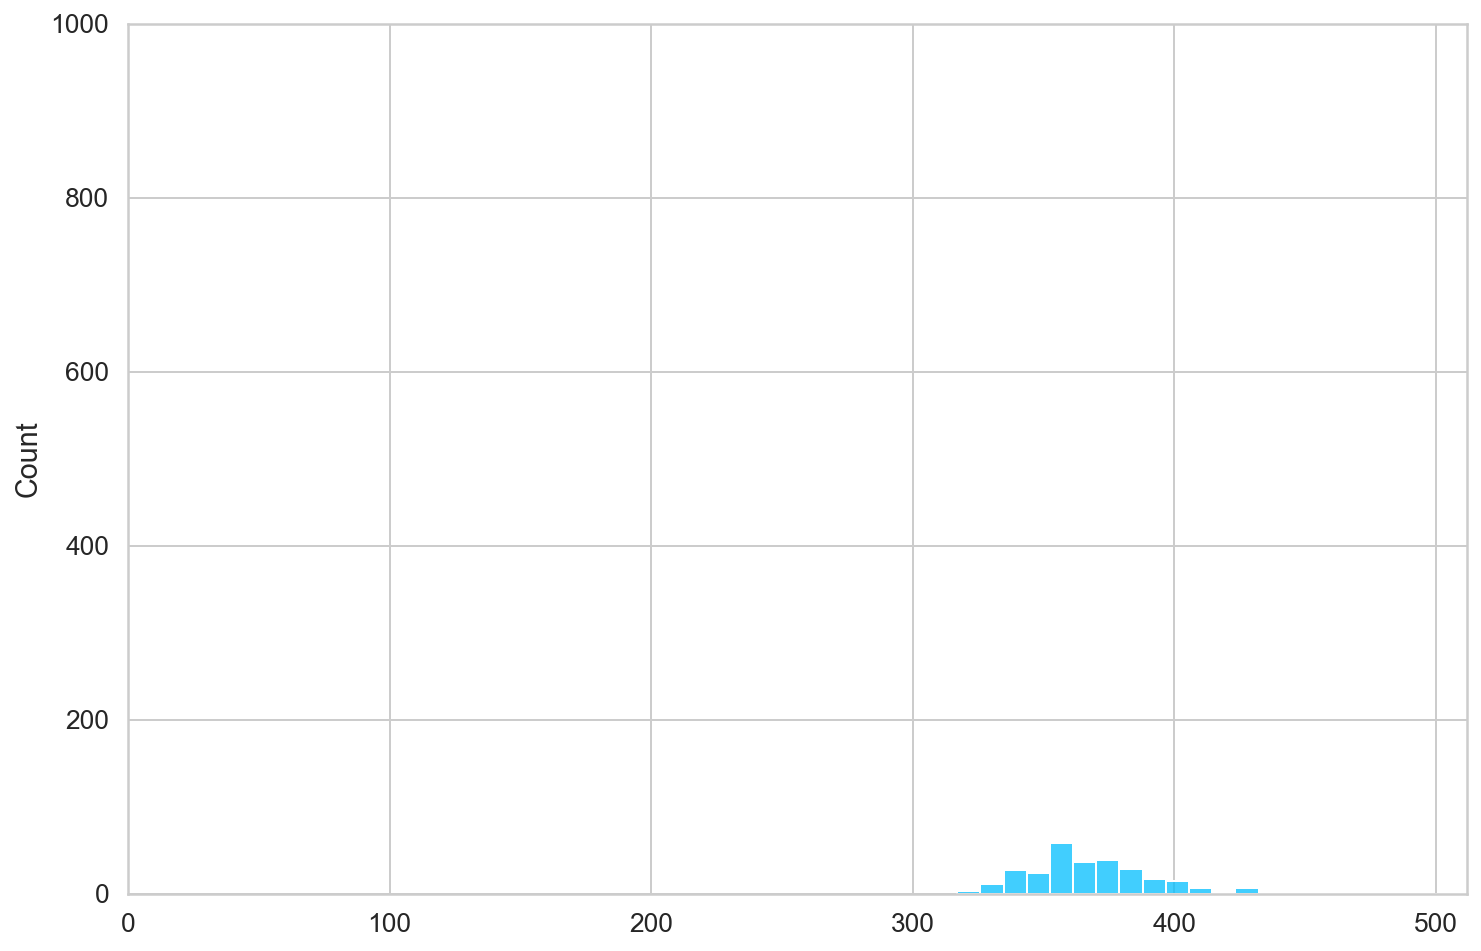

In [20]:
sns.histplot(token_counts)
plt.xlim([0, 512]);
plt.ylim([0, 1000]);

Most of the comments contain less than 300 tokens or more than 512. So, we'll stick with the limit of 512.

In [21]:
MAX_TOKEN_COUNT = 512

### Dataset

We'll wrap the tokenization process in a PyTorch Dataset, along with converting the labels to tensors:

In [22]:
class ToxicCommentsDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    body = data_row.body
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      body,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      body=body,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

Let's have a look at a sample item from the dataset:

In [23]:
train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['body', 'input_ids', 'attention_mask', 'labels'])

In [24]:
sample_item["body"]

'Xiao looked down at the bottle of wine in his hands. He read over the label; it was definitely from Fontaine, and it was definitely really expensive.\n\nHe looked back up at Zhongli, who\'d come to visit him at Wangshu Inn, "Why did you give this to me, again?" He raised an eyebrow. Morax knew that Xiao wasn\'t one for drinking; it was a human activity, something to keep them occupied during their short existence. But who was Xiao to refuse a gift from his god?\n\nHis god merely shrugged, "I was given too much, and it would be a shame to have to waste something as fine as this. I figured you would be able to find a use for it, even if it\'s not to drink it yourself. You could perhaps give it to Smiley Yanxiao for him to include in his cooking, or... Oh, I don\'t know, gift it to someone else." Morax got a knowing look on his face, one with softened eyes and a very slight smile. Xiao only narrowed his eyes at the look. "Well, I have to be off now. I suggest you be off as well." And wit

In [25]:
sample_item["labels"]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [26]:
sample_item["input_ids"].shape

torch.Size([512])

Let's load the BERT model and pass a sample of batch data through:

In [27]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

In [28]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [52]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=6)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/jui/opt/anaconda3/envs/MLTC_BERT_2/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/jui/opt/anaconda3/envs/MLTC_BERT_2/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'ToxicCommentsDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 

In [ ]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [30]:
output.last_hidden_state.shape, output.pooler_output.shape

NameError: name 'output' is not defined

The `768` dimension comes from the BERT hidden size:

In [31]:
bert_model.config.hidden_size

768

The larger version of BERT has more attention heads and a larger hidden size.

We'll wrap our custom dataset into a [LightningDataModule](https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html):

In [53]:
class ToxicCommentDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = ToxicCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=4
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=4
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=4
    )

`ToxicCommentDataModule` encapsulates all data loading logic and returns the necessary data loaders. Let's create an instance of our data module:

In [54]:
N_EPOCHS = 10
BATCH_SIZE = 12

data_module = ToxicCommentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

## Model

Our model will use a pre-trained [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and a linear layer to convert the BERT representation to a classification task. We'll pack everything in a [LightningModule](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html):


In [55]:
class ToxicCommentTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

Most of the implementation is just a boilerplate. Two points of interest are the way we configure the optimizers and calculating the area under ROC. We'll dive a bit deeper into those next.

### Optimizer scheduler

The job of a scheduler is to change the learning rate of the optimizer during training. This might lead to better performance of our model. We'll use the [get_linear_schedule_with_warmup](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup).

Let's have a look at a simple example to make things clearer:

In [56]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
  optimizer, 
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])

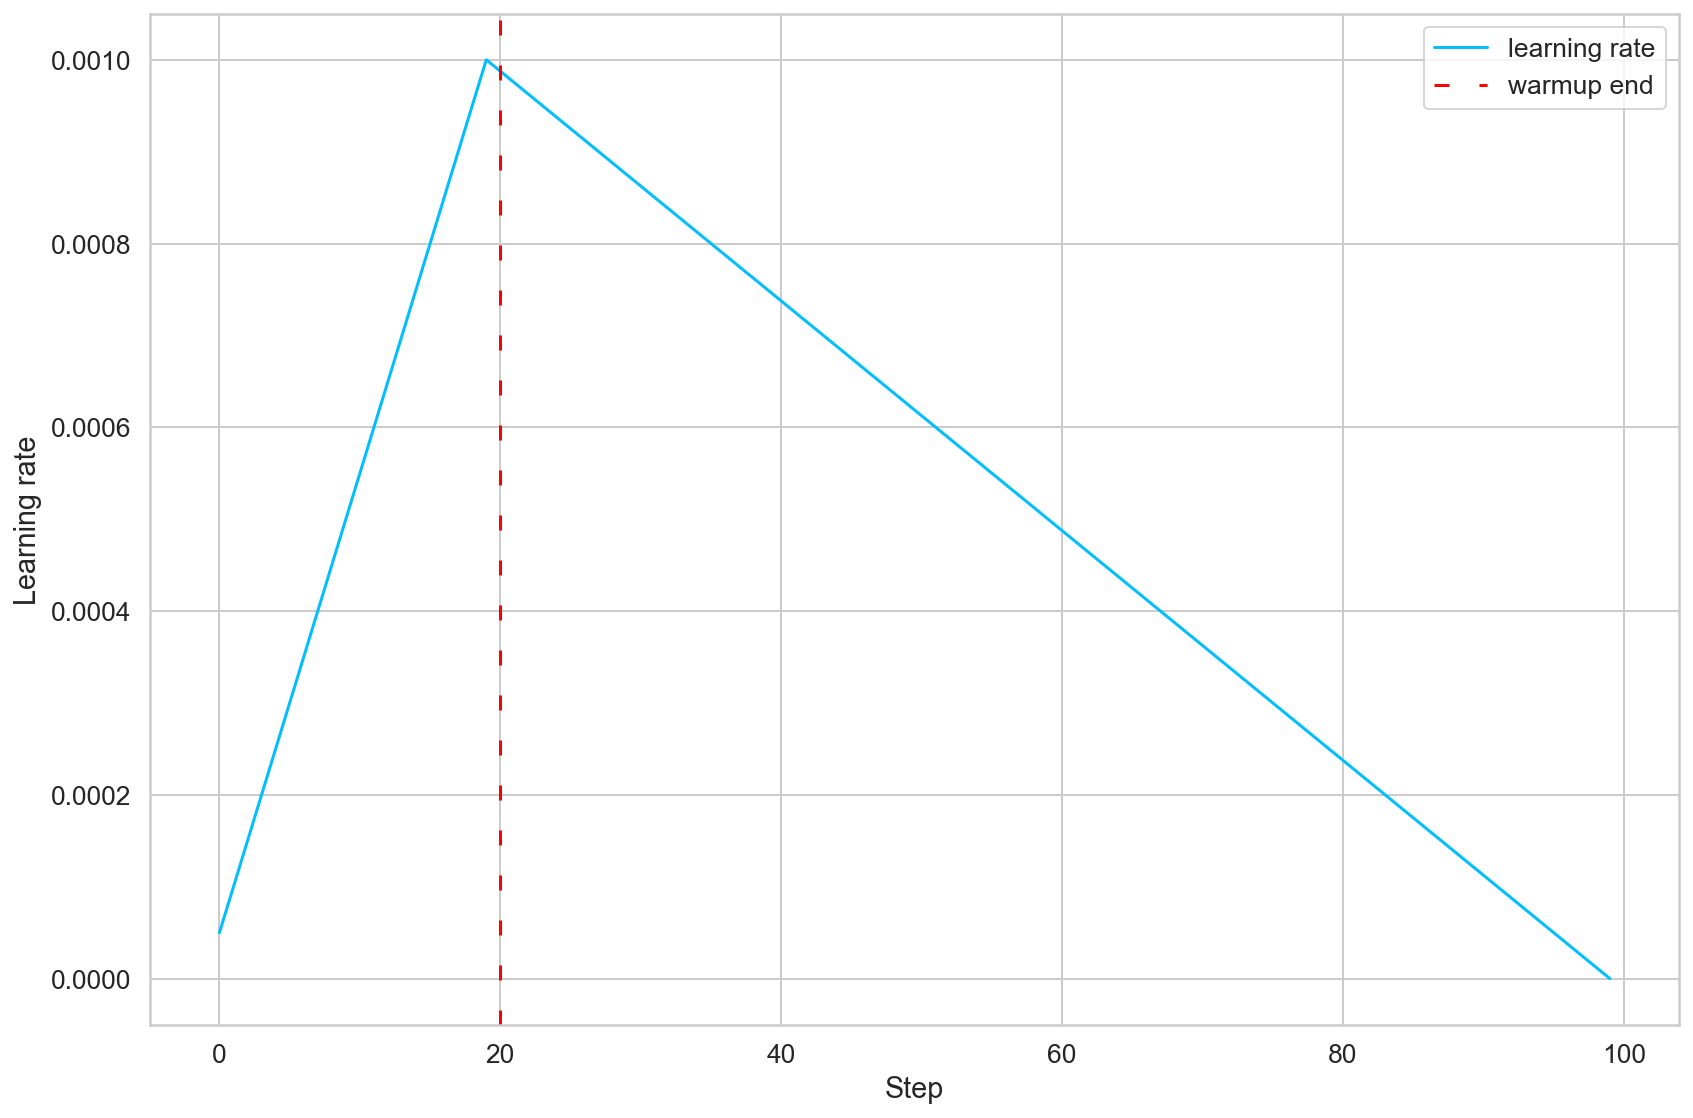

In [57]:
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

We simulate 100 training steps and tell the scheduler to warm up for the first 20. The learning rate grows to the initial fixed value of 0.001 during the warm-up and then goes down (linearly) to 0.

To use the scheduler, we need to calculate the number of training and warm-up steps. The number of training steps per epoch is equal to `number of training examples / batch size`. The number of total training steps is `training steps per epoch * number of epochs`:

In [58]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

We'll use a fifth of the training steps for a warm-up:

In [59]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(46, 230)

We can now create an instance of our model:

In [60]:
model = ToxicCommentTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

### Evaluation

Multi-label classification boils down to doing binary classification for each label/tag.

We'll use Binary Cross Entropy to measure the error for each label. PyTorch has [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), which we're going to combine with a sigmoid function (as we did in the model implementation). Let's look at an example:

In [61]:
criterion = nn.BCELoss()

prediction = torch.FloatTensor(
  [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)
labels = torch.FloatTensor(
  [1., 0., 0., 0., 1., 0.]
) 

In [62]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [63]:
criterion(torch.sigmoid(prediction), labels)

tensor(0.8725)

We can use the same approach to calculate the loss of the predictions:

In [42]:
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

NameError: name 'sample_batch' is not defined

In [ ]:
criterion(predictions, sample_batch["labels"])

#### ROC Curve

Another metric we're going to use is the area under the Receiver operating characteristic (ROC) for each tag. ROC is created by plotting the True Positive Rate (TPR) vs False Positive Rate (FPR):

$$
\text{TPR} = \frac{\text{TP}}{\text{TP} \text{+} \text{FN}}
$$

$$
\text{FPR} = \frac{\text{FP}}{\text{FP} \text{+} \text{TN}}
$$




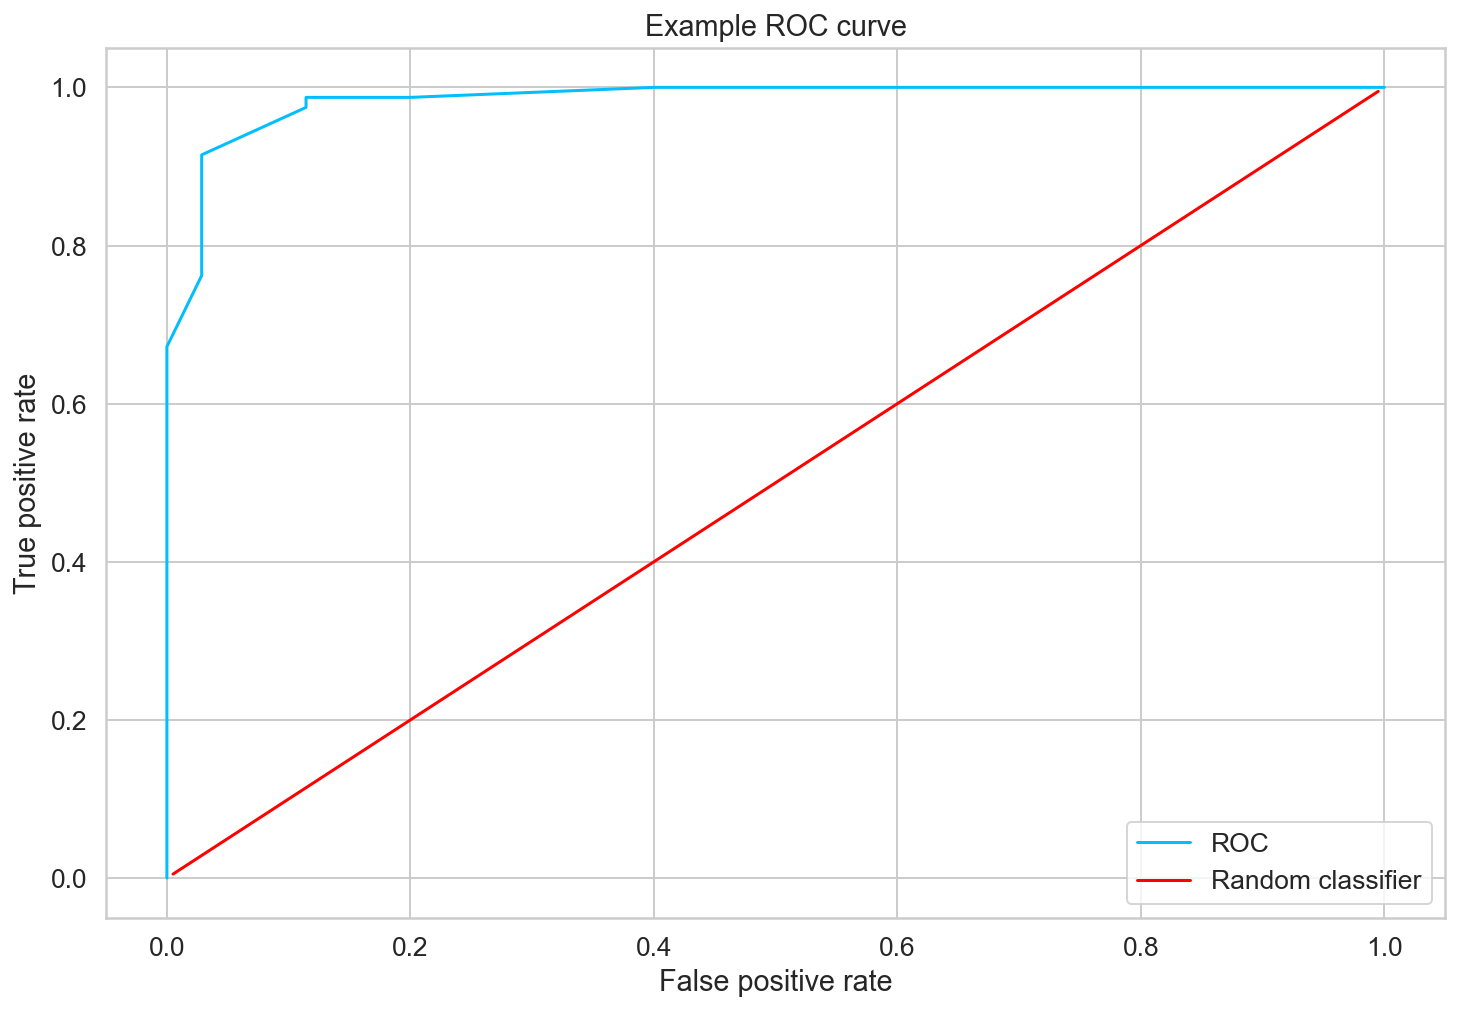

In [64]:
from sklearn import metrics

fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]

tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]

_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show();

## Training

In [44]:
!rm -rf lightning_logs/
!rm -rf checkpoints/

In [65]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


The beauty of PyTorch Lightning is that you can build a standard pipeline that you like and train (almost?) every model you might imagine. I prefer to use at least 3 components.

Checkpointing that saves the best model (based on validation loss):

In [66]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

Log the progress in TensorBoard:

In [67]:
logger = TensorBoardLogger("lightning_logs", name="toxic-comments")

And early stopping triggers when the loss hasn't improved for the last 2 epochs (you might want to remove/reconsider this when training on real-world projects):

In [68]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

We can start the training process:

In [69]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=0,
  progress_bar_refresh_rate=30
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [70]:
trainer.fit(model, data_module)


  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 7.7 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.272   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/jui/opt/anaconda3/envs/MLTC_BERT_2/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/jui/opt/anaconda3/envs/MLTC_BERT_2/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'ToxicCommentsDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 

The model improved for (only) 2 epochs. We'll have to evaluate it to see whether it is any good. Let's double-check the validation loss:

In [ ]:
trainer.test()

## Predictions

I like to look at a small sample of predictions after the training is complete. This builds intuition about the quality of the predictions (qualitative evaluation).

Let's load the best version (according to the validation loss) of our model:

In [ ]:
trained_model = ToxicCommentTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

We put our model into "eval" mode, and we're ready to make some predictions. Here's the prediction on a sample (totally fictional) comment:

In [ ]:
test_comment = "Hi, I'm Meredith and I'm an alch... good at supplier relations"

encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

Looks good. This one is pretty clean. We'll reduce the noise of the predictions by thresholding (0.5) them. We'll take only tag predictions above (or equal) to the threshold. Let's try something toxic:

In [ ]:
THRESHOLD = 0.5

test_comment = "You are such a loser! You'll regret everything you've done to me!"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  if prediction < THRESHOLD:
    continue
  print(f"{label}: {prediction}")

I definitely agree with those tags. It looks like our model is doing something reasonable, on those two examples.

## Evaluation

Let's get a more complete overview of the performance of our model. We'll start by taking all predictions and labels from the validation set:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = ToxicCommentsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

One simple metric is the accuracy of the model:

In [ ]:
accuracy(predictions, labels, threshold=THRESHOLD)

That's great, but you should take this result with a grain of salt. We have a very imbalanced dataset. Let's check the ROC for each tag:

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

Very good results, but just before we go party, let's check the classification report for each class. To make this work, we must apply thresholding to the predictions:

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0
))

That gives us a much more realistic picture of the overall performance. The model makes mistakes on the tags will low amounts of examples. What can you do about it?

## Summary

Great job, you have a model that can tell (to some extent) if a text is toxic (and what kind) or not! Fine-tuning modern pre-trained Transformer models allow you to get high accuracy on a variety of NLP tasks with little compute power and small datasets.

- [Read the tutorial](https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/14Ea4lIzsn5EFvPpYKtWStXEByT9qmbkj?usp=sharing)
- [Read the *Getting Things Done with Pytorch* book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

In this tutorial, you'll learned how to:

- Load, balance and split text data into sets
- Tokenize text (with BERT tokenizer) and create PyTorch dataset
- Fine-tune BERT model with PyTorch Lightning
- Find out about warmup steps and use a learning rate scheduler
- Use area under the ROC and binary cross-entropy to evaluate the model during training
- How to make predictions using the fine-tuned BERT model
- Evaluate the performance of the model for each class (possible comment tag)

Can you increase the accuracy of the model? How about better parameters or different learning rate scheduling? Let me know in the comments.



## References

- [Toxic comments EDA](https://www.kaggle.com/swathi314/toxic-comment-classification-eda)
- [Receiver operating characteristic on ML crash course](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)